In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from lmfit.models import GaussianModel

import image_analysis as ia # module with most of the code
import drop_detection_tools as ddt

%matplotlib notebook

## Extract frames from video

This needs to be done only once for every video

In [5]:
path = './T-data/18-11/'
video_name = 'B-ol10-aq30-spf1.wmv'

ia.extract_frames(path, video_name)

FileNotFoundError: No such file or directory

## Get arrays from video

In [2]:
folder = './T-data/18-11/B-ol10-aq30-spf1'

color = 1 # green

arrays, mean_array = ia.get_arrays(folder,color)

print(arrays.shape)

Image.fromarray(mean_array).show()

(299, 960, 1280)


## Subtract the mean

In [3]:
arrays_sub = ia.subtract_mean(arrays,mean_array)

m = -145.0, M = 154.0
Subtracting the bias will generate some overflow
Rescale arrays to avoid overflow? [y/n] y


In [4]:
# see an example

idx = 9

Image.fromarray(arrays[idx]).show()
Image.fromarray(arrays_sub[idx]).show()

## Rotation and gaussian filter

In [5]:
# test on one image

rotation = 32
filter_size = 3

img = ia.preprocess(arrays_sub[idx], rotation=rotation, filter_size=filter_size)
img.show()

In [6]:
# apply to all images
imgs = []
for array_sub in tqdm(arrays_sub):
    imgs.append(ia.preprocess(array_sub, rotation=rotation, filter_size=filter_size))

imgs = np.array(imgs,dtype=Image.Image)
# calibration image
calibr_img = ia.preprocess(arrays[idx], rotation=rotation, filter_size=0) # keep the image sharp

calibr_img.show()

100%|██████████| 299/299 [00:11<00:00, 25.70it/s]


## Channel analyzer

### Calibrate

In [7]:
c = ia.Channel_analyzer()

<IPython.core.display.Javascript object>


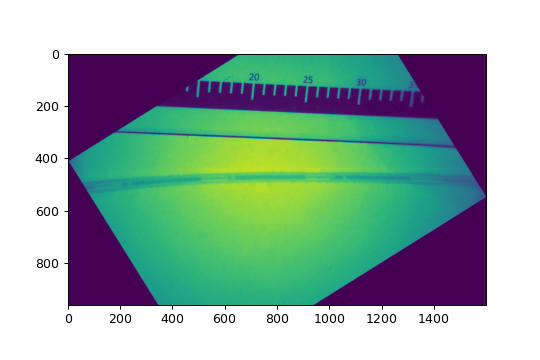

In [12]:
c.calibrate(calibr_img,15)

<IPython.core.display.Javascript object>


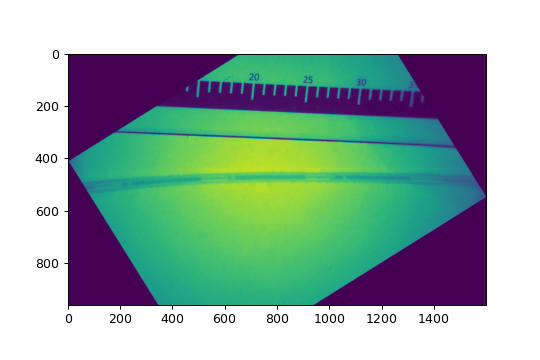

In [13]:
c.find_channel(calibr_img)

### Save calibration

In [16]:
c.save(name='calibr_B-ol10-aq30',folder='./T-data/18-11/')

./T-data/18-11/calibr_B-ol10-aq30 exists: overwrite? [y/n]n


### Load from existing calibration

In [8]:
c.load(name='calibr_B-ol10-aq30',folder='./T-data/18-11')

### Try analysis on one image

<IPython.core.display.Javascript object>


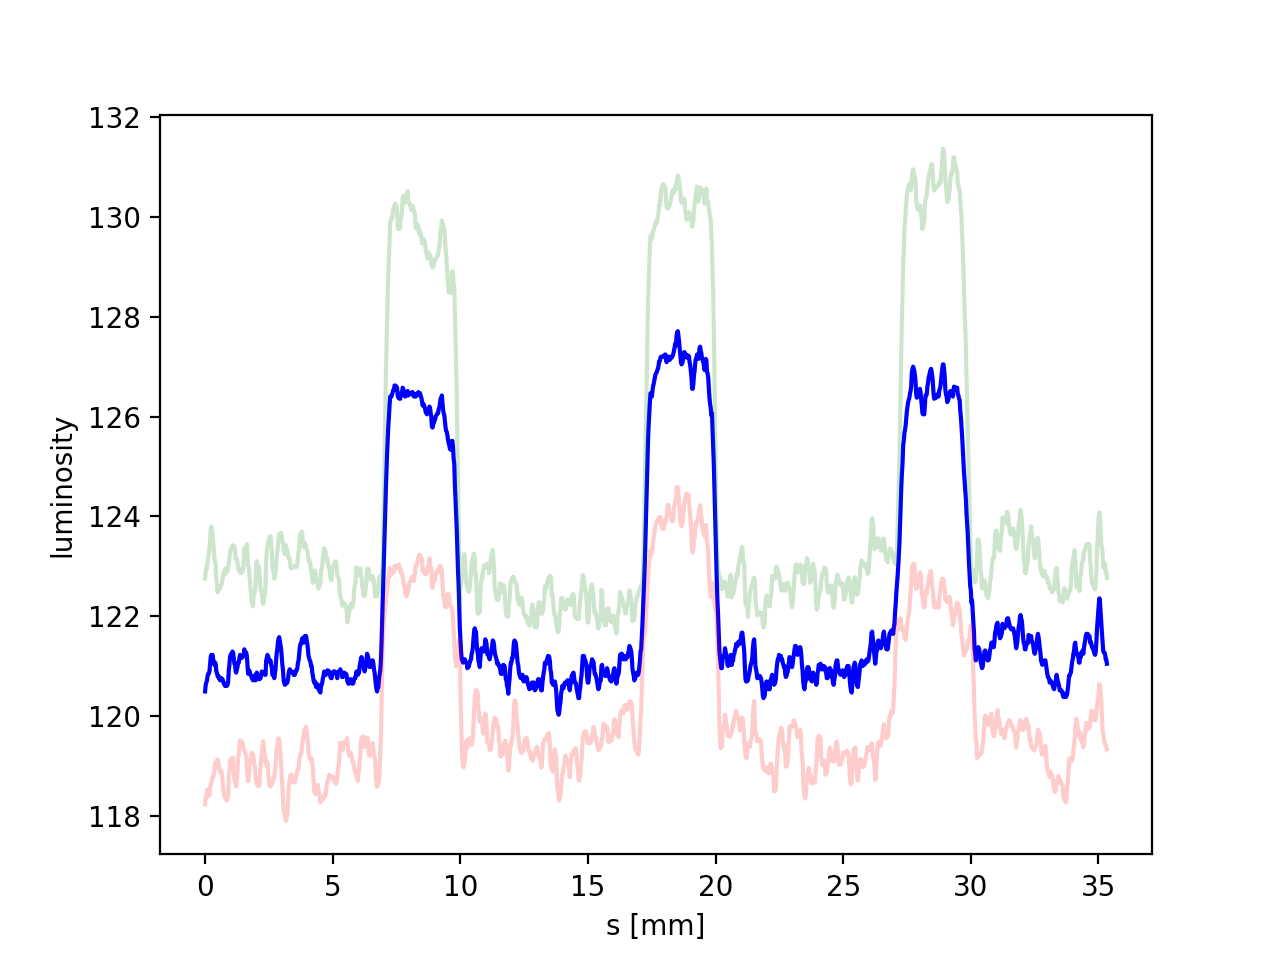

Text(0, 0.5, 'luminosity')

In [9]:
idx = 0

img = imgs[idx]
s, mean, std = c.evaluate(img)

plt.figure()
plt.plot(s,mean, color='blue')
plt.plot(s,mean - std,color='red',alpha=0.2)
plt.plot(s,mean + std,color='green',alpha=0.2)

plt.xlabel('s [mm]')
plt.ylabel('luminosity')

## Analyze the waveforms

In [10]:
s = 0.

means = []
stds = []

for idx in tqdm(range(len(imgs))):
    s, mean, std = c.evaluate(imgs[idx])
    means.append(mean)
    stds.append(std)

100%|██████████| 299/299 [00:17<00:00, 17.18it/s]


## Threshold searching and drop computing functions

In [24]:
# see drop_detection_tools

## Thresholds searching 

plotting


<Figure size 432x288 with 0 Axes>

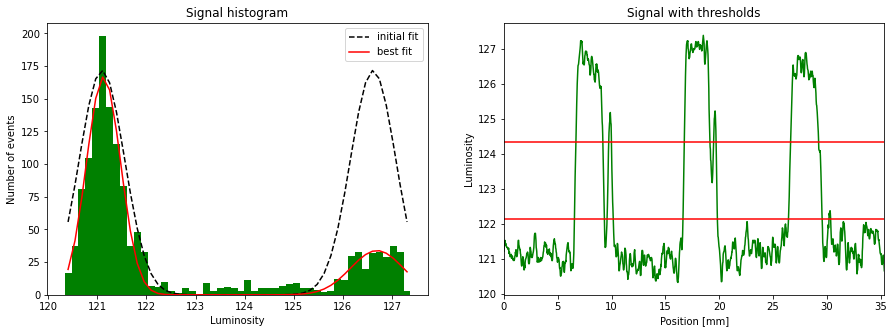

In [23]:
# Luminosity thresholds searching

#**************************************************
idx         = 6    # Frame index (checking plots)

nbins       = 50    # Histo bins number
plot_switch = True # Plots activation

#not needed
# ymin        = 120   # Plot min. luminosity
# ymax        = 130   # Plot max. luminosity
#**************************************************

%matplotlib inline

# Plot one single signal (checking)
thr_low, thr_high = ddt.thr_searcher(data=means[idx], nbins=nbins, t=s, plot_switch=plot_switch)

100%|██████████| 299/299 [00:15<00:00, 19.22it/s]


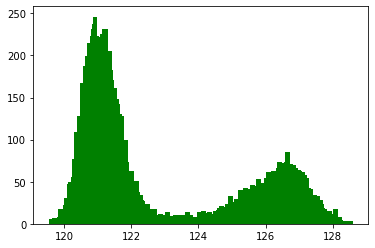

In [14]:
#for all images
thrs_low  = []    # thr_low array
thrs_high = []    # thr_high array

for mean in tqdm(means):
    thr_low, thr_high = ddt.thr_searcher(data=mean, nbins=nbins, t=s, plot_switch=plot_switch)
    thrs_low.append(thr_low)
    thrs_high.append(thr_high)

In [22]:
print(f'thrs_low: mean {np.mean(thrs_low)}, std {np.std(thrs_low,ddof=1)}')
print(f'thrs_high: mean {np.mean(thrs_high)}, std {np.std(thrs_high,ddof=1)}')

thrs_low: mean 122.18641036258207, std 0.2538114366315925
thrs_high: mean 123.10704567757743, std 1.695686328234292


## Drop detection 

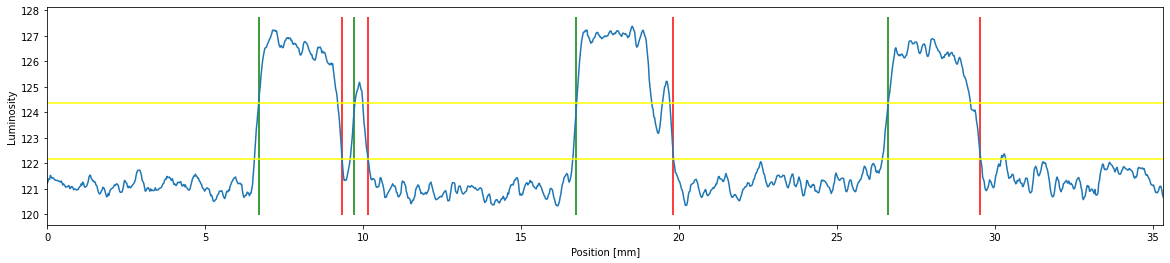

In [27]:
# Detection of the edges of the drops

#**************************************************
idx         = 6    # Frame index (checking plot)

plot_switch = True # Plots activation

# not needed
# xrange      = 35    # Plot x max.
# ymin        = 120   # Plot min. luminosity 
# ymax        = 130   # Plot max luminosity 
#**************************************************

# Plot one single signal (checking)
drop_start, drop_end = ddt.drop_det(time=s, data=means[idx], thr_low=thr_low, thr_high=thr_high,
                                    plot_switch=plot_switch)

In [35]:
#for all images
drop_starts = []    # drop_start array
drop_ends   = []    # drop_end array

for mean in means:
    drop_start, drop_end = ddt.drop_det(s, mean, thr_low, thr_high, ymin, ymax, xrange, plot_switch)
    drop_starts.append(drop_start)
    drop_ends.append(drop_end)

100%|███████████████████████████████████████████████████████████████████████████████| 299/299 [00:02<00:00, 121.55it/s]


## Velocity computing 

100%|█████████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 44752.86it/s]


Text(0, 0.5, 'Number of events')

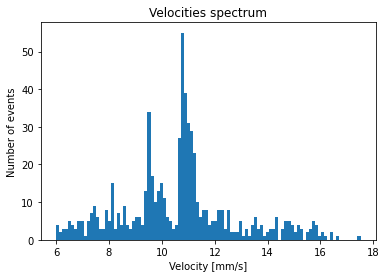

In [36]:
#******************************************************************************
imgs_switch = False        # Images activation
thr         = 6.           # Min. velocity acceptable [mm/s] 
vec         = drop_starts  # Velocity computed on 'drop_starts' or 'drop_ends'
#******************************************************************************

diffs = []

# iterate over frames
for idx in tqdm(range(len(vec) - 1)):
    delay_idx = -1
    exit = False
    diffs.append([])
    # iterate over droplets in a frame
    for i,drop in enumerate(vec[idx]):
        diff = 0.
        # look for the same droplet in the next frame
        while(diff < thr):
            delay_idx += 1
            try:
                diff = vec[idx + 1][delay_idx] - drop
            except(IndexError):
                exit = True
                break
        if exit:
            if len(diffs[-1]) == 1:
                if imgs_switch == True:
                    imgs[idx].show()
            break
        diffs[-1].append(diff)
        
# Plot 
plt.figure()
plt.hist(np.concatenate(diffs),bins = 100)
plt.title('Velocities spectrum')
plt.xlabel('Velocity [mm/s]')
plt.ylabel('Number of events')

Text(0, 0.5, 'velocity [mm/s]')

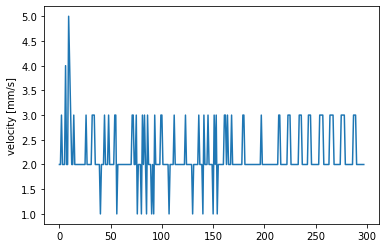

In [94]:
plt.figure()
plt.plot([len(diff) for diff in diffs])

plt.ylabel('velocity [mm/s]')